# Sonstige Beteiligung im Modul Angewandte Programmierung
**Dozent: Herr Dennis Glüsenkamp**

**Eingereicht von: Jannis Niesen**
![alt text](69837.png "Title")

### Inhaltsverzeichnis
* [Business Understaning](#BusinessUnderstaning)
* [Data Understanding und Data Preparation](#DataUnderstandingDataPreparation)
* [Modelling](#Modelling)
* [Evaluation](#Evaluation)


## Vorhersage von Mietpreisen (Kaltmieten)

## Business Understanding<a class="anchor" id="Business Understanding"></a>

Bei dem Anwendungsfall geht es darum, Mietpreise von Wohnungen in Deutschland möglichst genau vorherzusagen. 
Dabei handelt es sich um ein Regressionsproblem, welches mit einem Supervised Learning Algorithmus gelöst werden kann.
Die Daten kommen von dem Immobilienportal Immowelt. [[1]](#Immowelt)

## Datenbeschaffung

Um einen Datensatz mit Mietpreisen aus ganz Deutschland zu erstellen, wurde ein Webcrawler programmiert. Dieser sucht nach einem bestimmten Suchbegriff auf dem Imobilienportal Immowelt und extrahiert sowohl die Mietpreise, als auch andere Informationen, die für die Vorhersage dieser Mietpreise verwendet werden können.

### Immowelt Webcrawler

Der Code für den Webcrawler, einschließlich des verwendeten chromedrivers ist auf github in dem Repository Immowelt_Crawler hochgeladen. [[2]](#Github)

In [1]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import time


def get_housing_data(search_term, n_sites):
    """
    This function crawls information about apartments from immowelt.de.
    The function uses a chromedriver to navigate the site and BeautifulSoup to pull data out of the HTML

    Parameters
    ----------
    search_term : str
        The term to search for on immowelt.de
    n_sites : int
        Number of result pages to go through for each search term

    Returns
    ----------
    pandas DataFrame
        A DataFrame with the apartments on the first n_sites result pages containing six columns
        ("Description", "Price", "square-meters", "rooms", "address", "information")
    """
    # Input city to lowercase
    search_term = search_term.lower()

    # URL of target website
    url = "https://www.immowelt.de/"

    # load chrome webdriver with a Service
    driver = webdriver.Chrome(service = Service(ChromeDriverManager().install()))

    # call URL
    driver.get(url)

    # look for search bar
    search = driver.find_element(By.ID, 'tbLocationInput')

    # type string in search bar
    search.send_keys(search_term)

    # press return
    search.send_keys(Keys.RETURN)

    # Handling german Umlaute
    character = {"ä": "ae", "ö": "oe", "ü": "ue", "ß": "ss"}
    for char in character:
        search_term = search_term.replace(char, character[char])

    # wait for site to load
    time.sleep(2)

    # find apartments to click on
    soup = BeautifulSoup(driver.page_source, "html.parser")
    items = soup.find("div", {"class": "SearchList-22b2e"})

    result = []
    # Loop through the first n sites
    for i in range(1, n_sites + 1):
        if i != 1:
            # go to next site
            driver.get(f"https://www.immowelt.de/liste/{search_term}/wohnungen/mieten?d=true&sd=DESC&sf=RELEVANCE&sp={i}")

            time.sleep(2)
            # find next apartments
            soup = BeautifulSoup(driver.page_source, "html.parser")
            items = soup.find("div", {"class": "SearchList-22b2e"})

        # check if there are apartments
        if items is None:
            break

        # Loop through apartments and click all items (loop through children)
        for item in items.children:
            tag_element = item.findChild()

            # check if NoneType
            if tag_element is not None:
                link = tag_element.get("href")
                driver.get(link)
                time.sleep(2)

                # get data
                try:
                    name = driver.find_element(By.XPATH, '// *[ @ id = "aUebersicht"] / h1')
                    price = driver.find_element(By.XPATH,
                                                '//*[@id="aUebersicht"]/app-hardfacts/div/div/div[1]/div[1]/strong')
                    sm = driver.find_element(By.XPATH,
                                                 '//*[@id="aUebersicht"]/app-hardfacts/div/div/div[2]/div[1]/span')
                    rooms = driver.find_element(By.XPATH,
                                                '//*[@id="aUebersicht"]/app-hardfacts/div/div/div[2]/div[2]/span')
                    address = driver.find_element(By.XPATH, '//*[@id="aUebersicht"]/app-estate-address')
                    info_1 = driver.find_element(By.XPATH, '//*[@id="aImmobilie"]/sd-card')

                    result.append([name.get_attribute("textContent"), price.get_attribute("textContent"),
                                   sm.get_attribute("textContent"), rooms.get_attribute("textContent"),
                                   address.get_attribute("textContent"), info_1.get_attribute("textContent")])
                except:
                    print("exception")
    # quit driver
    driver.quit()

    # result as pandas data frame
    result = pd.DataFrame(result, columns=["Description", "Price", "square-meters", "rooms", "address", "information"])
    return (result)




### Informationen von Immowelt crawlen
Um eine aussagekräftige Datenbasis aufzubauen, wurden Wohnungen in den größten Städten Deutschlands (Satz-art 40) gecrawlt. Dafür wurde das Gemeindeverzeichnis (Stand 2020) des statistischen Bundesamts verwendet. Dieses enthält jede politisch selbständige Gemeinde in Deutschland und beinhaltet beispielsweise einen Gemeindeschlüssel, die Postleitzahl und andere Informationen. [[3]](#StatistischesBundesamt)

In [2]:
from Webcrawler import get_housing_data
import pandas as pd
import numpy as np

# get germanys biggest city as crawler input
cities = pd.read_excel("data/Gemeindeverzeichnis 2020.xlsx")

# Only bigger cities
cities = cities[cities["Satz-art"] == "40"]

# Prepare for crawler
cities = list(cities["Gemeindename"].str.split(",").str[0])

# Display the amount of cities
print(f'Crawling housing data for {len(cities)} cities')

# Only one city in jupyter-notebook
cities = cities[:1]

# Call crawler function on citys
housing_data_list = [get_housing_data(city, 1) for city in cities]

housing_data = pd.concat(housing_data_list)

# clean price and sm
housing_data["Price"] = housing_data["Price"].apply(lambda x: x.replace("€", "").replace(".", "").replace(",", "."))
housing_data["square-meters"] = housing_data["square-meters"].apply(lambda x: x.replace("m²", "").replace(".", "").replace(",", "."))

# Excel
# housing_data.to_excel("housing_data3.xlsx")




====== WebDriver manager ======
Current google-chrome version is 101.0.4951
Get LATEST chromedriver version for 101.0.4951 google-chrome


Crawling housing data for 401 cities


Driver [/Users/jannis/.wdm/drivers/chromedriver/mac64_m1/101.0.4951.41/chromedriver] found in cache


exception


## Data Understanding und Data Preparation<a class="anchor" id="#DataUnderstandingDataPreparation"></a>

### Erster Überblick über die Daten
Der Datensatz besteht aus den 6 Variablen: Description, Price, square-meters, rooms, address, information, die alle als object gespeichert sind. Es gibt insgesammt 10483 Zeilen und die Variable Description hat 7 fehlende Werte. Ahand der ersten 5 Zeilen lässt sich erkennen, dass Description, address und price Zeichenketten sind. Price, square-meters und rooms sind numerische Werte.

In [3]:
import nltk
import pandas as pd
import numpy as np
import requests
import geopandas as gpd
from shapely.geometry import Point
import requests
from numpy import nan
import collections
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# load crawler data
housing_data = pd.read_excel("data/housing_data.xlsx", index_col = 0)

# throw out Unnamed
housing_data = housing_data.drop(columns="Unnamed: 0")

# inspect data
housing_data.info()
housing_data.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10493 entries, 0 to 5296
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Description    10486 non-null  object
 1   Price          10493 non-null  object
 2   square-meters  10493 non-null  object
 3   rooms          10493 non-null  object
 4   address        10493 non-null  object
 5   information    10493 non-null  object
dtypes: object(6)
memory usage: 573.8+ KB


,Description,Price,square-meters,rooms,address,information
0,MODERNE und FREUNDLICHE 1-Zimmer-Wohnung in Fl...,600,51,1,Friesische Straße 2124937 Flensburg (Friesisc...,Die WohnungKategorieApartmentWohnungslage1. Ge...
1,Wohnen an der Bergmühle - Gemütliche 3-Zimmer-...,839.37,79.94,3,Bauer Landstraße 1724939 Flensburg (Nordstadt...,Die WohnungKategorieApartmentWohnungslage1. Ge...
2,Diakonie Betreutes Wohnen,430,58.46,2,Franz-Schubert-Hof 2024943 Flensburg (Engelsb...,Die WohnungWohnungslageErdgeschossBezug01.06.2...
3,Diakonie Betreutes Wohnen,350,43.18,2,Franz-Schubert-Hof 2024943 Flensburg (Engels...,Die WohnungWohnungslage6. GeschossBezugab sofo...
4,Penthouse-Wohnung mit traumhaften Fördeblick,1540,104.26,3,Straße nicht freigegeben24944 Flensburg (Mürw...,Die WohnungKategoriePenthouseWohnungslage4. Ge...


### Geokoordinaten der Wohnungen joinen
Über die Adresse lassen sich die Geokoordinaten (Breitengrad, Lägengrad) der Wohnungen ermitteln. Für diesen Zweck kann beispielsweise die kostenlose API OpenCage verwendet werden. Bei dieser kann ein kostenloser Account erstellt werden, sodass bis zu 2500 Anfragen pro Tag gesendet werden können. Die API sendet die Geokoordinaten der Wohnungen im JSON-Format. [[4]](#OpenCage)Aufgrund der Abfragenbeschränkung, wurden die Geokoordinaten über mehrere Tage verteilt abgerufen. Deshalb wird die API im Code nur für eine Zeile angefragt und die Ergebnisse werden anschließend als Excel eingelesen.

In [4]:
# Cleaning crawling data
housing_data = housing_data[~housing_data.address.str.contains("Straße nicht freigegeben")]
housing_data["address"] = housing_data.address.str.replace("Auf Karte ansehen", "")

# get lat long from address
coord_list = []

# subset due to api limitations (2.5k per day)
# housing_data = housing_data[:2500]
housing_data = housing_data[:1]

for index, row in housing_data.iterrows():
    link = f"https://api.opencagedata.com/geocode/v1/json?q={row.address}&key=bde3b179622541a9b24545f02697e461"
    response = requests.get(link)
    try:
        response = response.json()["results"][0]["geometry"]
    except:
        response = {"lat": 0,
                    "lng": 0}
    coord_list.append(response)

# create columns lat and lon
housing_data["lat"] = [appartement["lat"] for appartement in coord_list]
housing_data["lon"] = [appartement["lng"] for appartement in coord_list]


### Zusätzliche unabhängige Variablen ermitteln
#### Gemeindedaten
Um Informationen über die Lage der Wohnung für die Prognose zu verwenden, wurden drei regionale Variablen hinzugefügt. Für diese Informationen müssen die Wohnungen allerdings zunächst Gemeinden zugeordnet werden. Dafür können die Verwaltungsgebiete vom Bundesamt für Kartographie und Geodäsie verwendet werden. [[5]](#Gemeindedaten) Die Verwaltungsgebiete können beispielsweise als Shapefiles heruntergeladen werden. Shapefiles bieten ein standardisiertes Format zum Speichern von Vektordaten (Geodaten), welches beispielsweise von geografischen Informationssystemen verwendet wird. Innerhalb der Shapfiles unterscheidet man zwischen Punkt-, Polygon- und Linien-Elementen. [[6]](#Shapefiles) Die Verwaltungsgebiete sind in Polygonen gespeichert, welche zweidimensionale geschlossene Objekte, mit unendlichen vielen Punkten und Kanten sind. Deshalb werden sie häufig für die Darstellung von Grenzen (in diesem Fall Gemeindegrenzen) verwendet. Um in Python mit geografischen Daten zu arbeiten werden häufig die geopandas [[7]](#Geopandas) und die shapely [[8]](#Shapely) Library verwendet. Für die Zuordnung müssen zunächst die Geokoordinaten zu Point Objekten umgewandelt werden. Anschließend wird in dem geopandas shapefile mit den Verwaltungsgebieten nach den Punkten gesucht und den Wohnungen der passende Gemeinde Schlüssel zugeordnet.

In [5]:
# read in xlsx
housing_data = pd.read_excel("data/housing_data_cords.xlsx")

# read in shapefile data
gemeinde_data = gpd.read_file("data/vg250_01-01.gk3.shape.ebenen/vg250_ebenen_0101/VG250_GEM.shp")

# set the crs (coordinate reference system)
gemeinde_data = gemeinde_data.to_crs("EPSG:4326")

# get gemeinde key from shapefile data
gem_key = []

# iterate through coordinates and get gemeinde key
for index, row in housing_data.iterrows():
    cord_point = Point(row.lon, row.lat)
    bool_list = gemeinde_data.contains(cord_point)
    try:
        bool_index = bool_list[bool_list == True].index.values[0]
        gem_key.append(gemeinde_data["SDV_ARS"][bool_index])
    except:
        gem_key.append("")

housing_data["gemrs_20"] = gem_key


#### Raumtypen (RegioStaR7), Fläche der Gemeinde (gem_size_km2) und Einwohnerzahl der Gemeinde (gem_population) 
Durch den Gemeindeschlüssel können anschließend weitere Variablen zu dem Datensatz hinzugefügt werden. Zunächst werden Regiostar Daten als Excel-Datei eingelesen. Diese kommen von dem Bundesministerium für Digitales und Verkehr. Sie beihnalten Referenzdateien zur regionalstatistischen Raumtypologie, also beispielsweise die Variable RegioStaR7. Diese sagt aus, um welchen Raumtyp es sich bei der Gemeinde handelt. Bei den Raumtypen unterscheidet man zwischen Metropolen, Regiopolen, Großstädten, zentralen Städten, Mittelstädten, städtsichen Räumen, und kleinstädtischen, dörflichen Räumen. [[9]](#RegioStaR) Zusätzlich wird noch die Fläche sowie die Einwohnerzahl der Gemeinde über das Gemeindeverzeichnis in den Datensatz mit aufgenommen.

In [6]:
# load regiostar data
regiostar = pd.read_excel("data/regiostar-referenzdateien.xlsx", sheet_name = "ReferenzGebietsstand2020")

regiostar["gemrs_20"] = regiostar.gemrs_20.astype("string")

# remove leading zeros
housing_data["gemrs_20"] = [x.lstrip("0") for x in housing_data["gemrs_20"]]


# join regiostar
housing_data = pd.merge(housing_data, regiostar.loc[:, ["gemrs_20", "RegioStaR7"]], how = "left", on = "gemrs_20")

# make var explainable
housing_data["RegioStaR7"] = housing_data["RegioStaR7"].replace({71: "Metropole",
                                                                 72: "Regiopole",
                                                                 73: "Großstadt",
                                                                 74: "Zentrale Stadt",
                                                                 75: "Mittelstadt",
                                                                 76: "Städtischer Raum",
                                                                 77: "Kleinstadt / Dorf"})

# clean df
housing_data = housing_data.loc[:, "Description":]

# fill to 12 digits
housing_data["gemrs_20"] = [x.zfill(12) for x in housing_data["gemrs_20"]]

# clean gemrs_20
housing_data["gemrs_20"] = [x[0:9] for x in housing_data["gemrs_20"]]

# Join Bevölkerung
bev_data = pd.read_excel("data/Gemeindeverzeichnis 2020.xlsx", dtype = {"gem_20": str})
bev_data = bev_data[~bev_data["Bev_Insgesamt"].isna()]

housing_data = pd.merge(housing_data, bev_data[["gem_20", "Fläche km2 ", "Bev_Insgesamt"]], how = "left", left_on = "gemrs_20", right_on = "gem_20")

# Rename
housing_data = housing_data.rename(columns= {"Fläche km2 ": "gem_size_km2",
                                             "Bev_Insgesamt": "gem_population",
                                             "Description": "description",
                                             "Price": "price",
                                             "RegioStarR7": "regioStarR7"})

housing_data = housing_data.drop(columns=["gem_20", "gemrs_20"])

print(housing_data.head())

                                         description    price square-meters  \
0  MODERNE und FREUNDLICHE 1-Zimmer-Wohnung in Fl...     600            51    
1  Wohnen an der Bergmühle - Gemütliche 3-Zimmer-...  839.37         79.94    
2                          Diakonie Betreutes Wohnen     430         58.46    
3                          Diakonie Betreutes Wohnen     350         43.18    
4  Hier warten 50 m² zum Wohlfühlen auf Sie - san...     700            50    

  rooms                                            address  \
0     1  Friesische Straße 2124937 Flensburg  (Friesisc...   
1     3    Bauer Landstraße 1724939 Flensburg  (Nordstadt)   
2     2   Franz-Schubert-Hof 2024943 Flensburg  (Engelsby)   
3     2  Franz-Schubert-Hof  2024943 Flensburg  (Engelsby)   
4     1   Paul-Ziegler-Str. 3a24939 Flensburg  (Nordstadt)   

                                         information        lat      lon  \
0  Die WohnungKategorieApartmentWohnungslage1. Ge...  54.779949  9.42232   


#### Balcony und floor
Die Variable information, enthält einige zusätzliche Informationen über die Wohnung als String hintereinander geschrieben. Unteranderem steht in der Variable information, ob die Wohnung einen Balkon hat und auf welcher Etage die Wohnung liegt. Um die Variable balcony anzulegen, wird mit der string.find() Methode in information nach dem Wort "Balkon" oder "balkon" gesucht. Wenn dieses vorkommt, hat die Wohnung einen Balkon und die boolean Variable balcony wird auf true gesetzt. Für die Variable floor wird in information nach Geschoss gesucht, dieses ist in den Daten immer groß geschrieben. Anschließend wird die Nummer die vor Geschoss steht, als Etage in floor geschrieben. Wenn die Wohnung im Erdgeschoss liegt, wir 0 in floor geschrieben. Anschließend können die Variablen address und information entfernt werden, da sie keinen Mehrwert für die Analyse mehr bieten

In [7]:
# add a few variables
housing_data["balcony"] = ["Balkon" in x or "balkon" in x for x in housing_data["information"]]

housing_data["floor"] = [x[x.find("Geschoss") - 3:x.find("Geschoss")-2] for x in housing_data["information"]]

# Erdgeschoss
floor = []
for index, row in housing_data.iterrows():
    if row["floor"].isnumeric():
        floor.append(row["floor"])
    else:
        floor.append("Erdgeschoss" in row["information"] or "erdgeschoss" in row["information"])

housing_data["floor"] = floor

# Ergeschoss = 0, missing = nan
housing_data["floor"] = [nan if x == False else 0 if x == True else x for x in housing_data["floor"]]

# no need for information and address anymore
housing_data = housing_data.drop(columns=["information", "address"])

# clean price
housing_data["price"] = [float(x) if any(char.isdigit() for char in x) else 0 for x in housing_data.price]
housing_data = housing_data[housing_data["price"] >0]

# Number of words per Desription
housing_data = housing_data[~housing_data["description"].isna()]
housing_data["description"] = housing_data["description"].astype("string")
housing_data["des_length"] = [len(des.split()) for des in housing_data["description"]]

housing_data = housing_data.drop(columns="description")


housing_data.to_excel("data/housing.xlsx")

print(housing_data.head())

    price square-meters rooms        lat      lon   RegioStaR7  gem_size_km2  \
0  600.00           51      1  54.779949  9.42232  Mittelstadt         56.73   
1  839.37        79.94      3  54.784310  9.43961  Mittelstadt         56.73   
2  430.00        58.46      2  54.790251  9.47007  Mittelstadt         56.73   
3  350.00        43.18      2  54.790251  9.47007  Mittelstadt         56.73   
4  700.00           50      1  54.784310  9.43961  Mittelstadt         56.73   

   gem_population  balcony floor  des_length  
0         89934.0    False     1           6  
1         89934.0     True     1           9  
2         89934.0     True     9           3  
3         89934.0    False     6           3  
4         89934.0    False   NaN          14  


### Explanatory Data Analysis (EDA)
#### Verteilung der abhängigen Variable (price) analysieren
Die Variable price ist die abhängige Variable, die so genau wie möglich prognostiziert werden soll. Um ein Gefühl für die Verteilung zu bekommen, wird die Verteilung zunächst in einem Boxplot dargestellt. In diesem ist zu erkennen, dass die Variable price sehr viele Ausreißer hat. Als Ausreißer können die Werte bezeichnet werden, die mehr als 1,5 * den Interquartilabstand von der Box entfernt sind. Damit die Prognosequalität nicht durch die Ausreißer verschlechtert wird, werden diese Wohnungen aus dem Datensatz entfernt. Anschließend ist die Variable relativ gleichmäßig verteilt und der Median liegt bei ungefähr 570.

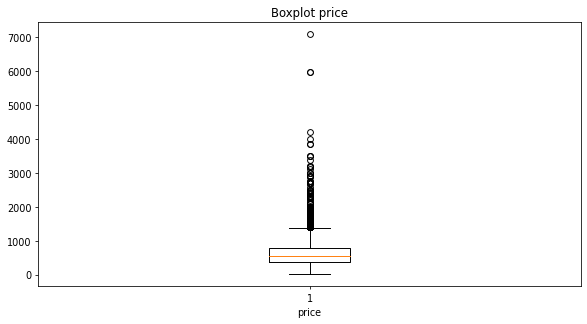

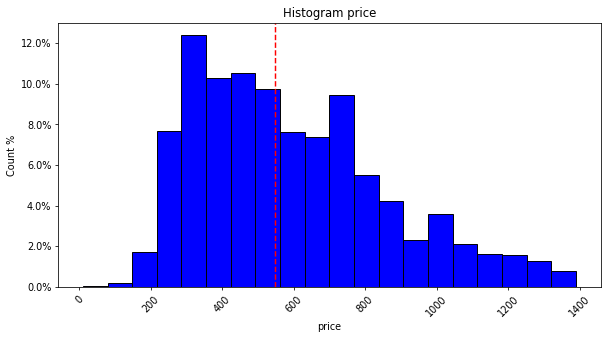

In [8]:
# Import packages
import collections

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import folium
import branca.colormap as cm
from matplotlib.ticker import PercentFormatter
from sklearn.preprocessing import LabelEncoder


%matplotlib inline
# Configure plot size
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 70

# Read in data
housing_data = pd.read_excel("data/housing.xlsx", index_col=0, decimal = ",")
housing_data["floor"] = housing_data["floor"].astype("string")
housing_data = housing_data[housing_data["square-meters"] != "kA"]
housing_data["square-meters"] = housing_data["square-meters"].astype("float64")
housing_data = housing_data[housing_data["rooms"] != "k.A."]
housing_data["rooms"] = housing_data["rooms"].astype("float64")

# Analyse price
# Outlier?
price_boxplot = plt.boxplot(housing_data.price)
plt.xlabel("price")
plt.title("Boxplot price")
plt.show()

# Remove outliers and nans
housing_data = housing_data[~housing_data["price"].isnull()]
per25, per75 = np.percentile(housing_data.price, [25, 75])
outlier = (per75 - per25) * 1.5 + per75

housing_data = housing_data[housing_data["price"] <= outlier]

# Function Histogramm
def histo(data, var):
    """
    This function creates a histogram based on the variable specified in var.
    The y-axis shows the relation as percentage. The red line marks the median value of var.

    Parameters
    ----------
    data : pandas DataFrame
        The dataset containing var
    var : str
        The variable to plot a histogram with

    Returns
    ----------
    matplotlib pyplot
        A histogram showing the distribution of the variable var
    """
    plt.hist(data[var], bins=20, color="b", edgecolor="k", weights=np.ones(len(data[var])) / len(data[var]))
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.axvline(data[var].median(), color="r", linestyle="dashed")
    plt.xlabel(var)
    plt.ylabel("Count %")
    plt.title(f'Histogram {var}')
    plt.tick_params(axis="x", rotation=45)
    plt.show()

# Histogram of price
histo(housing_data, "price")


#### Verteilung der metrische unabhängigen Variablen
Bevor die Verteilung der metrischen unabhängigen Variaben analysiert wird, werden noch ein einige offensichtliche Ausreißer entfernt. Wohnungen die mehr als 500 Quadratmeter haben, Wohnungen mit mehr als 7 Räume und Wohnungen mit 2.1 Räumen. Bei der Verteilung der Variablen fallen die großen Unterschiede bei der Gemeindegröße und der Gemeindeeinwohnerzahl auf.Hier gibt es einige wenige Gemeinden, welche die Verteilung verzerren. Allerdings werden diese nicht aus dem Datensatz entfernt, dass es sich bei diesen um große Städte handelt, die Teil der Analyse sein sollen. Die Wohnungen haben im Median ungefähr 62 Quadratmeter, die Gemeinden sind im Median ungefähr 65 Quadratkilometer groß und haben im Median ungefähr 45000 Einwohner. Der Median der Beschreibungslänge liegt zwischen 6 und 7 Wörtern.

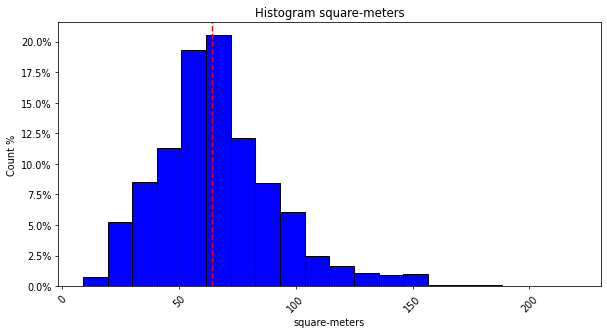

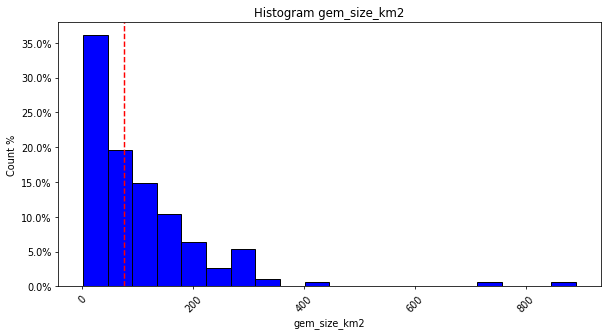

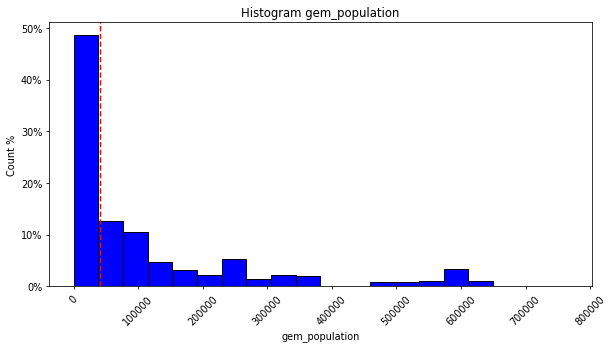

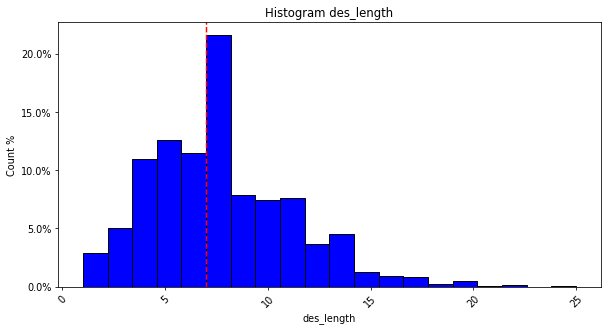

In [9]:
# Remove obvious outliers and clean data
housing_data = housing_data[housing_data["square-meters"] <= 500]
housing_data = housing_data[housing_data["rooms"] < 7.0]
housing_data = housing_data[housing_data["rooms"] != 2.1]

# Analyse distribution

# square-meters
housing_data = housing_data[housing_data["square-meters"] != "kA"]
housing_data["square-meters"] = housing_data["square-meters"].astype("float")
histo(housing_data, "square-meters")

# gem_size_km2
histo(housing_data, "gem_size_km2")

# gem_population
histo(housing_data[housing_data["gem_population"] < 1000000], "gem_population")

# des_length
histo(housing_data, "des_length")


#### Verteilung der kategorialen unabhängigen Variablen
Anschließend kann die Verteilung der kategorialen Variablen mit einem Säulendiagramm dargestellt werden. Bei der Anzahl der Räume ist zu erkennen, dass ein Großteil der Wohnungen zwischen 1 und 3 Räume hat. 25 Prozent der Wohnungen liegen in einer Gemeinde, die zu den Regiopolen (also Städte aßerhalb von Metropolregionen) gezählt wird. Bezüglich der Variable Balkon lässt siche sagen, dass 56% der Wohnungen keinen Balkon haben. Die Verteilung ist hier also relativ ähnlich. Außerdem liegen ungefähr 50% der Wohnungen im ersten oder zweiten Stock, wobei es auch einige Wohnungen im 9. Stock gibt.

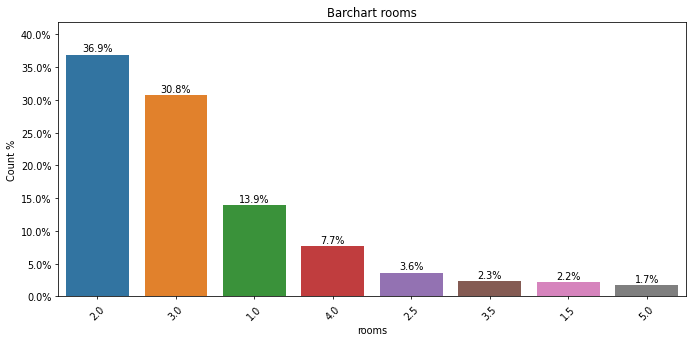

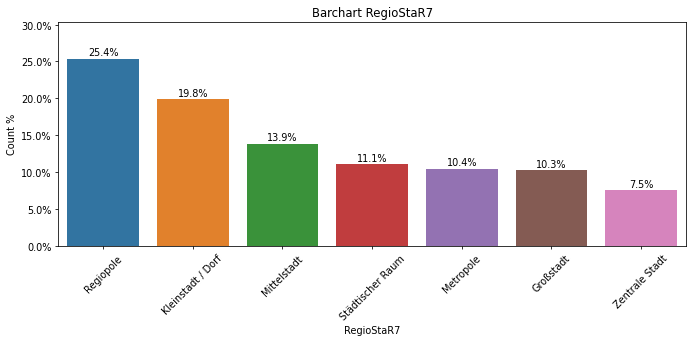

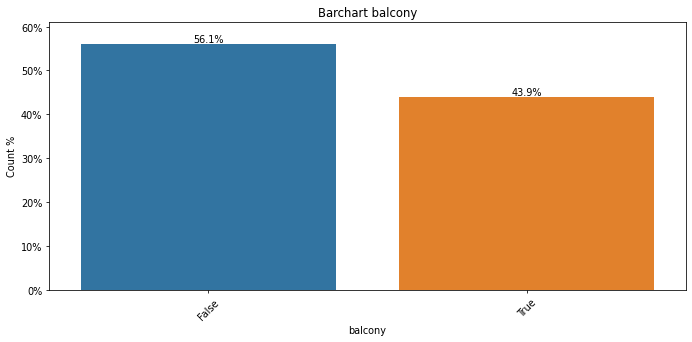

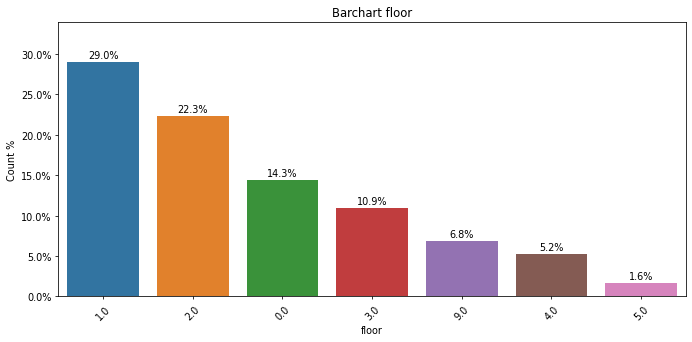

In [10]:
# function bar chart
def bar(data, var):
    """
    This function creates a bar chart based on the variable specified in var.
    The y-axis shows the relation as percentage.

    Parameters
    ----------
    data : pandas DataFrame
        The dataset containing var
    var : str
        The variable to plot a bar chart with

    Returns
    ----------
    matplotlib pyplot
        A bar chart showing the distribution of the variable var
    """
    df = data.groupby(var)[var].count().to_frame()
    df = pd.DataFrame({"value": df.index, "percentage": df[var] / len(data)})
    df = df[df["percentage"] >= 0.001]
    df = df.sort_values("percentage", ascending=False).reset_index()
    df["value"] = df["value"].astype("string")
    df = df[df["percentage"] >= 0.01]

    df_plot = sns.barplot(x="value", y="percentage", data=df)
    for index, value in enumerate(df.percentage):
        plt.text(index, value + 0.005,
                 f"{value:.1%}", ha="center")
    plt.xlabel(var)
    plt.ylabel("Count %")
    plt.ylim(0, df["percentage"][0] + 0.05)
    plt.title(f'Barchart {var}')
    df_plot.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
    plt.tick_params(axis="x", rotation=45)
    plt.tight_layout()
    plt.show()


# rooms
bar(housing_data, "rooms")

# RegioStaR7
bar(housing_data, "RegioStaR7")

# balcony
bar(housing_data, "balcony")

# floor
bar(housing_data, "floor")

#### Verteilung der Wohnungen in Deutschland
Mit den Wohnungskoordinaten kann die Verteilung der Wohnungen auf der Deutschlandkarte gezeigt werden. Geokoordinaten in Python anschaulich darzustellen kann das Modul Folium verwendet werden.[[10]](#Folium) Die Folium Maps lassen sich nicht gut in einem Jupyter Notebook darstellen, deshalb wurden die Maps als html gespeichert. Diese können einfach im Browser geöffnet werden. Auf der ersten Karte ist die Position der Wohnungen durch einen blauen Kreis dargestellt. Hier lässt sich erkennen, dass die Wohnungen über ganz Deutschland verteilt sind. Außerdem ist auffällig, dass es viele Wohnungen in Großstädten wie Hamburg, Köln oder Berlin liegen. In dem zweiten Plot sind die Kreise nach dem Wohnugspreis gefärbt. Günstigere Wohnungen sind gelb und teurere Wohnungen rot. Hier fällt besonders auf, dass Wohnungen im Osten in der Regel günstiger, als Wohnungen im Westen sind.

In [16]:
# Plot lat long with Folium
germany_coords = [51.163361, 10.447683]

# build map
germany_map = folium.Map(location=germany_coords, zoom_start=7)

# add flats
for index, row in housing_data.iterrows():
    folium.CircleMarker(location=[row["lat"], row["lon"]]).add_to(germany_map)

# save map
germany_map.save("germany_map.html")

# There are flats outside of germany
# Remove those
# bb of germany
housing_data = housing_data[housing_data["lat"].between(47.3024876979, 54.983104153) &
                            housing_data["lon"].between(5.98865807458, 15.0169958839)]


# Price and lat lon
# build map
germany_map_price = folium.Map(location=germany_coords, zoom_start=7)

# create color palette
palette = cm.LinearColormap(colors=["yellow", "red"],
                            vmin = housing_data.price.min(), vmax=housing_data.price.max())

# add flats
for index, row in housing_data.iterrows():
    folium.CircleMarker(location=[row["lat"], row["lon"]], radius = 14,
                  fill = True, color = palette(row["price"]), popup = str(row["price"])).add_to(germany_map_price)

germany_map_price.add_child(palette)
# save map
germany_map_price.save("germany_map_price.html")

#### Umgang mit fehlenden Werten
In dem Datensatz haben nur die Variablen floor, gem_size_km2, gem_population und RegioStaR7 fehlende Werte. Wobei floor mit 8 Prozent der Wohnunge, die meisten fehlenden Werte hat. Die anderen Variablen haben so wenige fehlende Werte, sodass diese Wohnungen einfach entfernt werden können. Da floor zu viele fehlende Werte hat, werden diese durch den Median von floor ersetzt. Dieser liegt bei 2. Anschließend hat der Datensatz 

In [12]:
# Fill missing values

# Are there missing values?
# NAs
NAS = housing_data.isna().sum().to_frame("Nas")
NAS = pd.DataFrame({"variable": NAS.index, "percentage": (NAS.Nas / len(housing_data))* 100})
NAS = NAS[NAS["percentage"] >0]
NAS = NAS.sort_values("percentage", ascending=False).reset_index()

print(NAS)

# Remove the few gem_size_km2 and gem_population nas
housing_data = housing_data[~housing_data["gem_size_km2"].isna()]

# There are too many nas in floor to remove all of them
# Fill with median
housing_data["floor"] = housing_data["floor"].astype("float")
housing_data["floor"].fillna(housing_data["floor"].median(), inplace=True)

# There are no nas left
housing_data.info()

            index        variable  percentage
0           floor           floor    8.008855
1    gem_size_km2    gem_size_km2    0.026045
2  gem_population  gem_population    0.026045
3      RegioStaR7      RegioStaR7    0.013023
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7677 entries, 0 to 8237
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price           7677 non-null   float64
 1   square-meters   7677 non-null   float64
 2   rooms           7677 non-null   float64
 3   lat             7677 non-null   float64
 4   lon             7677 non-null   float64
 5   RegioStaR7      7677 non-null   object 
 6   gem_size_km2    7677 non-null   float64
 7   gem_population  7677 non-null   float64
 8   balcony         7677 non-null   bool   
 9   floor           7677 non-null   float64
 10  des_length      7677 non-null   int64  
dtypes: bool(1), float64(8), int64(1), object(1)
memory usage: 667.2+ KB


#### Zusammenhang zwischen den unabhängigen und der abhängigen Variable untersuchen
Im folgenden wird die Variable price auf Zusammenhänge mit den anderen Variablen untersucht.

#### Metrische Variablen
Um den Zusammenhang zwischen den metrischen Variablen und price zu untersuchen kann ein Scatterplot mit einer Regregressionsgeraden verwendet werden. Die Regressiongerade (in rot dargestellt), ist das Ergebnis einer Linearen Regression. Mit dieser lässt sich die Effektstärke des Zusammenhangs zwischen den Variablen untersuchen. So hat die Variable square-meters beispielsweise eine positive Auswirkung auf die Variable price. Die Variable lat hingegen hat eine negative Auswirkung auf price. Das unterstreicht die Erkenntniss der Price Map, wo zu sehen war, dass Wohnungen im Osten günstiger sind. gem_population und des_length haben beide positive Auswirkungen auf price, während sich die Variable lon eher negativ auswirkt. Bei der Variable gem_size_km2 ist keine Steigung zu erkennen.

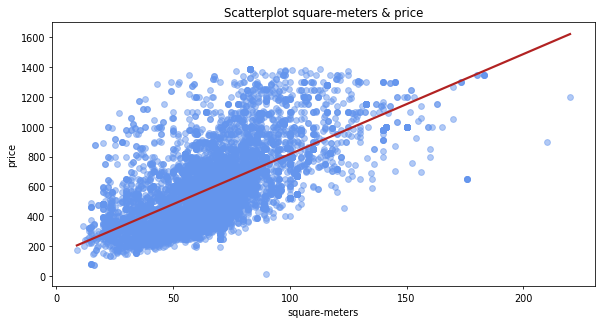

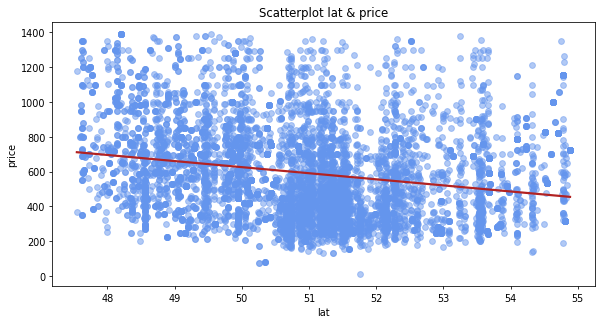

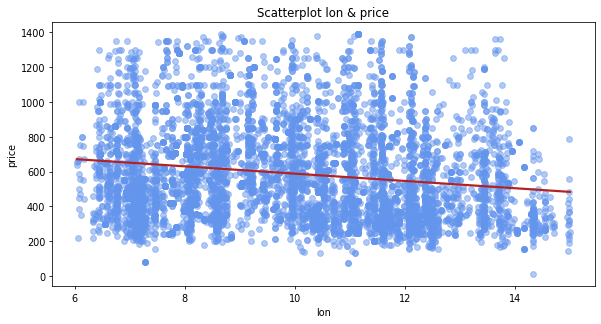

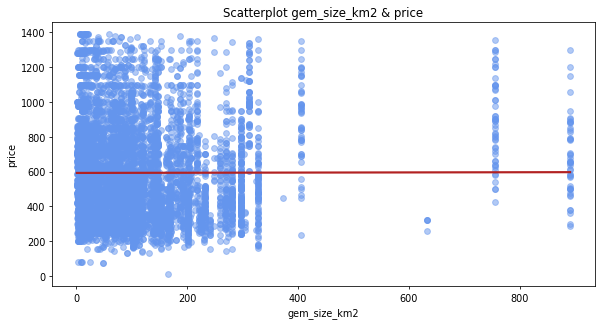

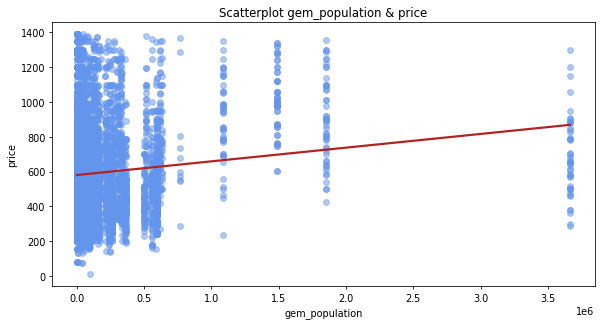

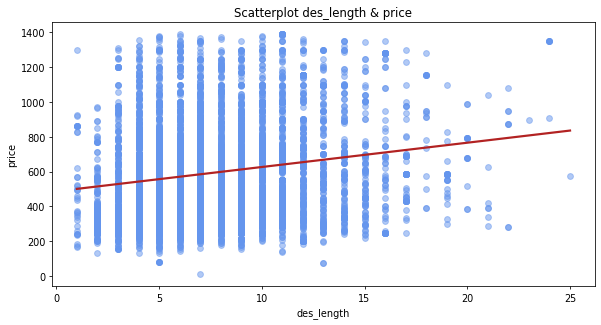

In [13]:
# Understanding relationships
# Price and all other variables
# scatter function
import warnings

# to ignore seaborn warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

def scatter_plot(data, var_x, var_y):
    """
    This function creates a scatter plot with var_x on the x-axis and var_y on the y-axis.

    Parameters
    ----------
    data : pandas DataFrame
        The dataset containing var_x and var_y
    var_x : str
        The variable on the x-axis
    var_y : str
        The variable on the y-axis

    Returns
    ----------
    matplotlib pyplot
        A scatter plot with the variables var_x and var_y
    """
    sns.regplot(var_x, var_y, data = data, ci = None,
           scatter_kws={"color": "cornflowerblue", "alpha": 0.5}, line_kws={"color": "firebrick"})
    plt.xlabel(var_x)
    plt.ylabel(var_y)
    plt.title(f'Scatterplot {var_x} & {var_y}')
    plt.show()


# square-meters
scatter_plot(housing_data, "square-meters", "price")

# lat
scatter_plot(housing_data, "lat", "price")

# lon
scatter_plot(housing_data, "lon", "price")

# gem_size_km2
scatter_plot(housing_data, "gem_size_km2", "price")

# gem_population
scatter_plot(housing_data, "gem_population", "price")

# des_length
scatter_plot(housing_data, "des_length", "price")


#### Kategoriale Variablen
Der Zusammenhang zwischen den kategorialen Variablen und dem Preis kann mit Boxplots visualisiert werden. Hier wird deutlich, dass sich price im Median je nach Anzahl der Räume stark unterscheidet. Generell ist der Preis in Wohnungen mit mehr Räumen grundsätzlich auch höher. Bei den Variablen RegioStaR7 und balcony gibt es nur kleine Unterschiede, was den Preis im Median angeht. Bei der Variable floor läasst sich sagen, dass Wohnungen in den tieferen Etagen grundsätzlich teurer sind. Wobei Wohnungen im achten Stock hier einen Ausreißer darstellen.

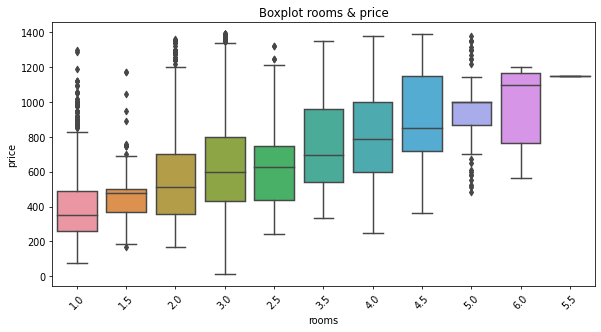

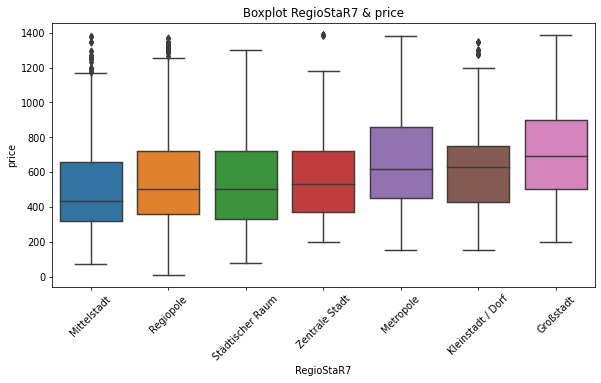

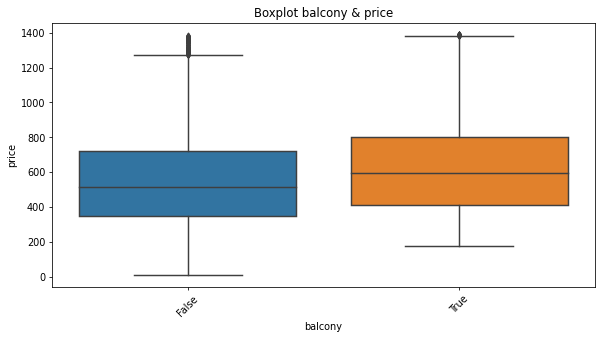

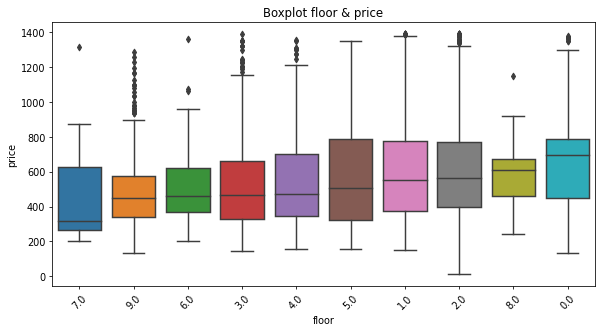

In [14]:
# boxplot function
def box(data, var_x, var_y):
    """
    This function creates a boxplot with var_x on the x-axis and var_y on the y-axis.

    Parameters
    ----------
    data : pandas DataFrame
        The dataset containing var_x and var_y
    var_x : str
        The variable on the x-axis
    var_y : str
        The variable on the y-axis

    Returns
    ----------
    matplotlib pyplot
        A boxplot with the variables var_x and var_y
    """
    order = data.groupby(var_x).median().sort_values(var_y)
    sns.boxplot(x=var_x, y = var_y, order = order.index, data = data)
    plt.xlabel(var_x)
    plt.ylabel(var_y)
    plt.title(f'Boxplot {var_x} & {var_y}')
    plt.tick_params(axis="x", rotation=45)
    plt.show()
    
# rooms
box(housing_data, "rooms", "price")

# RegiostaR7
box(housing_data, "RegioStaR7", "price")

# balcony
box(housing_data, "balcony", "price")

# floor
box(housing_data, "floor", "price")


# Save data
housing_data.to_excel("data/housing_data_prepped.xlsx")

## Modelling<a class="anchor" id="Modelling"></a>
Wie zu Beginn im Business Understanding geschrieben, handelt es sich bei der Vorhersage von Wohnungspreisen um ein Regressionsproblem, welches mit einem supervised Learning Algorithmus gelöst werden kann. Ein großer Teil der supervised Learning ALgorithmen sind die treee-based-Algorithmen, die Entscheidungsbäume für die Vorhersage verwenden.So unterscheidet man beispielsweise zwischen Decision Tress, Random Forests oder Boosted Trees. Um Overfitting zu vermeiden (gute Trainingsgenauigkeit aber schlechte Übertragbarkeit auf neue Daten) und gute Prognosen zu erziehlen, wurde für diesen Anwendungsfall der Random Forest verwendet. Da die Algorithmen des sklearn Moduls nur nummerische Werte nehmen, muss die Variable RegioStaR7 zunächst encoded werden. Dabei wird jeder Kategorie eine Zahl zugewiesen. Anschließend werden die Daten in Trainings- und Testdaten aufgeteilt. Hier werden in der Regel 20 Prozent der Daten zum testen des Modells verwendet. Anschließend kann ein Random Forest trainiert werden. Es wird einee Grid Search genutzt, um 3 verschiedene Cross Validation Datensätze zu erstellen, mit denen dann die Hyperparameter getuned werden. Es werden also immer wieder Modelle mit den verschiedenen Hyperparameter Kombinationen und den Bootstrapped Datensätzen erstellt. Anschließend werden die Hyperparameter, die das beste Modell erzeugt haben für das finale Modell verwendet. Für einen Random Forest können viele verschiedenen Hyperparamter verwendet werden. Für diesen Anwendungsfall wurden die Hyperparameter min_samples_split, max_features, max_samples und max_depth für die Grid Search verwendet. 

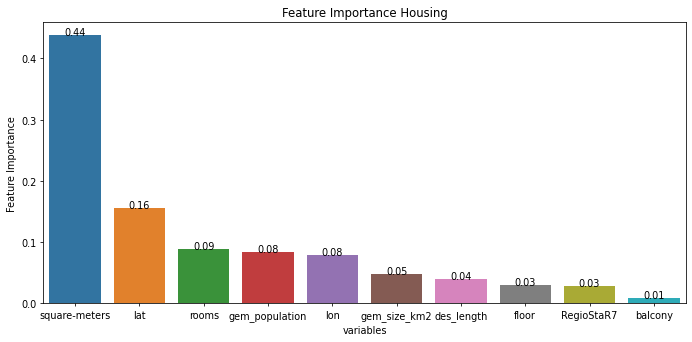

In [18]:
# Import packages
import pandas as pd
import math
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error


housing_data = pd.read_excel("data/housing_data_prepped.xlsx", index_col=0, decimal = ",")

# Encode RegioStaR7
encoder = LabelEncoder()
housing_data["RegioStaR7"] = encoder.fit_transform(housing_data["RegioStaR7"])

# train and test split
housing_train, housing_test = train_test_split(housing_data,
                                               test_size=0.2,
                                               random_state=3)

# Random Forest with Cross Validation
housing_DT = RandomForestRegressor(random_state=3)
housing_params = {"min_samples_split": [2, 3, 3, 4],
                  "max_features": [4, 5, 6, 7, 8],
                  "max_samples": [0.5, 0.6, 0.7,  0.8],
                  "max_depth": [14, 16, 18, 20]}

housing_CV = GridSearchCV(housing_DT, housing_params, cv = 3)

print(housing_CV)

Anschließend wird das finale Modell trainiert.

In [ ]:
# create fit
housing_CV.fit(housing_train.drop(columns="price"), housing_train["price"])
housing_CV_res = pd.DataFrame(housing_CV.cv_results_).sort_values(by=["rank_test_score"])

# feature importance
housing_importance = pd.DataFrame({"variables": housing_data.drop(columns="price").columns,
                                   "FI": housing_CV.best_estimator_.feature_importances_})

housing_importance = housing_importance.sort_values("FI", ascending=False).reset_index()

sns.barplot(x="variables", y="FI", data= housing_importance)
for index, value in enumerate(housing_importance.FI):
    plt.text(index, value,
             str(round(value, 2)), ha="center")
plt.xlabel("variables")
plt.ylabel("Feature Importance")
plt.title(f'Feature Importance Housing')
plt.tight_layout()

# make predictions with test data
housing_preds = housing_CV.predict(housing_test.drop(columns="price"))
# Encode RegioStaR7
encoder = LabelEncoder()
housing_data["RegioStaR7"] = encoder.fit_transform(housing_data["RegioStaR7"])

## Evaluation<a class="anchor" id="Evaluation"></a>

In [ ]:
print(mean_squared_error(housing_test["price"], housing_preds, squared=False))
print(mean_absolute_error(housing_test["price"], housing_preds))

# Analyse predictions
plt.scatter(housing_test["price"], housing_preds)
plt.plot([housing_test["price"].min(), housing_test["price"].max()],
         [housing_test["price"].min(), housing_test["price"].max()], "k--", lw=4)
plt.xlabel('Price')
plt.ylabel('Predicted price')
plt.title("Actual price vs. predicted price")
plt.show()

housing_test.insert(1, "preds", housing_preds)
housing_data.head()

## Quellen

[1] <a class="anchor" id="Immowelt"></a>Immowelt: https://www.immowelt.de/

[2] <a class="anchor" id="Github"></a>Github Immowelt_Crawler: https://github.com/LeIx1999/Immowelt_Crawler

[3] <a class="anchor" id="StatistischesBundesamt"></a>Statistisches Bundesamt Gemeindeverzeichnis: https://www.destatis.de/DE/Themen/Laender-Regionen/Regionales/Gemeindeverzeichnis/_inhalt.html

[4] <a class="anchor" id="OpenCage"></a>OpenCage Geocoding API: https://opencagedata.com/api

[5] <a class="anchor" id="Gemeindedaten"></a>Bundesamt für Kartographie und Geodäsie: https://gdz.bkg.bund.de/index.php/default/digitale-geodaten/verwaltungsgebiete/verwaltungsgebiete-1-5-000-000-ebenen-stand-31-12-vg5000-ebenen-12-31.html

[6] <a class="anchor" id="Schapefiles"></a>Technische Beschreibung Shapefiles: https://www.esri.com/content/dam/esrisites/sitecore-archive/Files/Pdfs/library/whitepapers/pdfs/shapefile.pdf

[7] <a class="anchor" id="Geopandas"></a>Geopandas Library: https://www.esri.com/content/dam/esrisites/sitecore-archive/Files/Pdfs/library/whitepapers/pdfs/shapefile.pdf

[8] <a class="anchor" id="Shapefiles"></a>Geopandas Shapefiles: https://www.esri.com/content/dam/esrisites/sitecore-archive/Files/Pdfs/library/whitepapers/pdfs/shapefile.pdf

[9] <a class="anchor" id="Folium"></a>RegioStaR: https://python-visualization.github.io/folium/